## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image

## Functions

In [2]:
def lorenz_system(state, sigma, beta, rho):
    """
    Define o sistema de equações diferenciais de Lorenz.

    Parameters:
        state (array): Vetor de estado [x, y, z].
        sigma (float): Parâmetro sigma.
        beta (float): Parâmetro beta.
        rho (float): Parâmetro rho.

    Returns:
        array: Derivadas dx/dt, dy/dt, dz/dt.
    """
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

In [3]:
def runge_kutta_4(f, state, dt, *params):
    """
    Aplica o método de Runge-Kutta de quarta ordem (RK4) para resolver ODEs.

    Parameters:
        f (function): Função que define o sistema de ODEs.
        state (array): Vetor de estado no tempo atual.
        dt (float): Passo de tempo.
        *params: Parâmetros adicionais para a função `f`.

    Returns:
        array: Novo vetor de estado após o passo de tempo.
    """
    k1 = f(state, *params)
    k2 = f(state + 0.5 * dt * k1, *params)
    k3 = f(state + 0.5 * dt * k2, *params)
    k4 = f(state + dt * k3, *params)
    return state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [4]:
def simulate_lorenz(initial_state, sigma, beta, rho, dt, steps, output_dir="output", filename="trajectory.dat"):
    """
    Simula o sistema de Lorenz usando o método RK4 e salva a trajetória em um arquivo .dat.

    Parameters:
        initial_state (array): Vetor de estado inicial [x0, y0, z0].
        sigma (float): Parâmetro sigma.
        beta (float): Parâmetro beta.
        rho (float): Parâmetro rho.
        dt (float): Passo de tempo.
        steps (int): Número de passos de simulação.
        output_dir (str): Diretório para salvar o arquivo de saída.
        filename (str): Nome do arquivo de saída.

    Returns:
        array: Trajetória simulada do sistema de Lorenz.
    """
    # Inicializa a trajetória
    trajectory = np.zeros((steps, len(initial_state)))
    trajectory[0] = initial_state

    # Simula a trajetória
    for i in range(1, steps):
        trajectory[i] = runge_kutta_4(lorenz_system, trajectory[i-1], dt, sigma, beta, rho)

    # Cria o diretório de saída, se necessário
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)

    # Salva a trajetória em um arquivo .dat
    np.savetxt(filepath, trajectory, header="X Y Z", comments="", fmt="%.6f")
    print(f"Trajetória salva em: {filepath}")

    return trajectory

In [5]:
def save_lorenz_frames(trajectory, output_dir, step=1):
    """
    Salva a evolução temporal do sistema Lorenz como frames em uma pasta, pulando frames com base no parâmetro step.

    Parameters:
        trajectory (array): Trajetória simulada do sistema de Lorenz.
        output_dir (str): Caminho para salvar os frames.
        step (int): Número de passos a serem pulados entre frames salvos.
    """
    import os
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.colors import Normalize
    from mpl_toolkits.mplot3d import Axes3D

    os.makedirs(output_dir, exist_ok=True)

    # Normalização e colormap
    norm = Normalize(vmin=0, vmax=len(trajectory))
    colors = cm.autumn(norm(range(len(trajectory))))

    for i in range(1, len(trajectory), step):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Desenhar os segmentos da trajetória com cores
        for j in range(1, i):
            ax.plot(
                trajectory[j - 1:j + 1, 0],
                trajectory[j - 1:j + 1, 1],
                trajectory[j - 1:j + 1, 2],
                color=colors[j - 1],
                lw=0.5
            )

        # Personalização do grid
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

        ax.set_title("Atractor de Lorenz", fontsize=14)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        # Salva o frame
        frame_path = os.path.join(output_dir, f"frame_{i:04d}.png")
        plt.savefig(frame_path)
        plt.close(fig)

In [6]:
def plot_lorenz(trajectory):
    """
    Plota a trajetória do sistema de Lorenz em 3D.

    Parameters:
        trajectory (array): Trajetória simulada do sistema de Lorenz.
    """
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    from matplotlib.colors import Normalize

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Configuração de cores em tons de vermelho e dourado
    norm = Normalize(vmin=0, vmax=len(trajectory))
    colors = cm.autumn(norm(range(len(trajectory))))

    for i in range(len(trajectory) - 1):
        ax.plot(trajectory[i:i+2, 0], trajectory[i:i+2, 1], trajectory[i:i+2, 2], color=colors[i], lw=0.5)

    # Personalização do grid
    ax.grid(True, linestyle='--', linewidth=0.3, color='gray', alpha=0.5)

    ax.set_title("Atractor de Lorenz", fontsize=14)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [7]:
def create_gif_from_frames_incremental(input_dir, output_file, duration=50):
    """
    Cria um GIF a partir de uma sequência de frames, carregando um frame por vez.

    Parameters:
        input_dir (str): Diretório contendo os frames.
        output_file (str): Nome do arquivo de saída para o GIF.
        duration (int): Duração de cada frame no GIF em milissegundos.
    """
    
    from PIL import Image
    import os
    # Obtém todos os arquivos da pasta ordenados
    frame_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".png")])
    
    if not frame_files:
        raise ValueError("Nenhum arquivo .png encontrado no diretório.")

    # Abre o primeiro frame
    first_frame_path = os.path.join(input_dir, frame_files[0])
    first_frame = Image.open(first_frame_path)

    # Adiciona os outros frames de forma incremental
    def frame_generator():
        for frame_file in frame_files[1:]:
            frame_path = os.path.join(input_dir, frame_file)
            yield Image.open(frame_path)

    # Cria o GIF
    first_frame.save(
        output_file,
        save_all=True,
        append_images=frame_generator(),
        duration=duration,
        loop=0
    )
    print(f"GIF salvo em: {output_file}")


In [8]:
import os

def delete_all_files(directory):
    """
    Apaga todos os arquivos dentro de um diretório.

    Parameters:
        directory (str): Caminho do diretório.
    """
    if not os.path.exists(directory):
        print(f"O diretório '{directory}' não existe.")
        return

    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):  # Verifica se é um arquivo
            os.remove(file_path)
            print(f"Arquivo apagado: {file_path}")

    print(f"Todos os arquivos do diretório '{directory}' foram apagados.")

In [9]:
#delete_all_files("output")

# Case 1

## Input

In [10]:
# Parâmetros do sistema de Lorenz
sigma1 = 10.0
rho1 = 0.5
beta1 = 8.0 / 3.0

# Condições iniciais e configuração da simulação
initial_state1 = np.array([1.0, 1.0, 1.0])
dt1 = 0.01
steps1 = 10000

## Main

Trajetória salva em: output\case1.dat


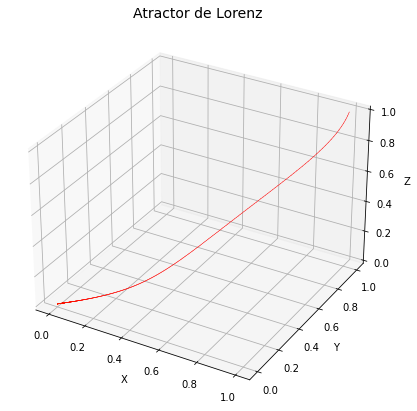

GIF salvo em: lorenz_attractor_case_1.gif


In [11]:
# Executa a simulação
trajectory1 = simulate_lorenz(initial_state1, sigma1, beta1, rho1, dt1, steps1,filename='case1.dat')

# Salva a evolução temporal
output_directory1 = "lorenz_frames_case_1"
save_lorenz_frames(trajectory1, output_directory1,100)
    
# Plota o resultado
plot_lorenz(trajectory1)

# Cria o GIF
gif_output1 = "lorenz_attractor_case_1.gif"
create_gif_from_frames_incremental("lorenz_frames_case_1", gif_output1)

## Analysis
### rho1 = 0.5
- **Behaviour:** with rho1 = 0.5, the system is far below the critical Rayleigh number (Rc), where chaotic dynamics typically emerge. The system is in a **stable equilibrium** state
- **Numerical results:** The trajectory rapidly converges to a fixed point, indicating that the fluid flow stabilizes into a steady state. The system's motion is dissipative and settles into a non-oscillatory regime.
- **Graph:** The trajectory spirals inward towards a single attractor (a fixed point in phase space).

# Case 2

## Input

In [12]:
# Parâmetros do sistema de Lorenz
sigma2 = 10.0
rho2 = 28.0
beta2 = 8.0 / 3.0

# Condições iniciais e configuração da simulação
initial_state2 = np.array([1.0, 1.0, 1.0])
dt2 = 0.01
steps2 = 10000

## Main

Trajetória salva em: output\case2.dat


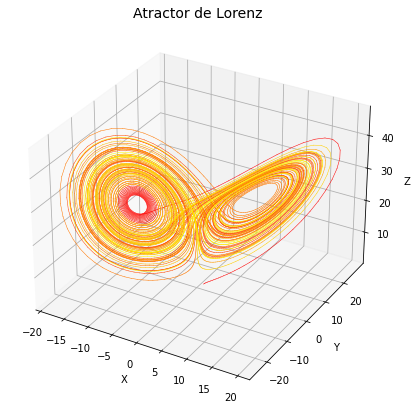

GIF salvo em: lorenz_attractor_case_2.gif


In [13]:
# Executa a simulação
trajectory2 = simulate_lorenz(initial_state2, sigma2, beta2, rho2, dt2, steps2,filename='case2.dat')

# Salva a evolução temporal
output_directory2 = "lorenz_frames_case_2"
save_lorenz_frames(trajectory2, output_directory2,100)
    
# Plota o resultado
plot_lorenz(trajectory2)

# Cria o GIF
gif_output2 = "lorenz_attractor_case_2.gif"
create_gif_from_frames_incremental("lorenz_frames_case_2", gif_output2)

## Analysis
### rho2 = 28
- **Behaviour:** This is the classic case studied by Lorenz and corresponds to chaotic dynamics. rho2 = 28 is above the critical Rayleigh number (Rc = 24.74), where the system transitions from steady-state solutions to chaotic attractors.
- **Numerical results:** The trajectory exhibits the characteristic butterfly-shaped attractor, oscillating irregularly between two lobes. This is a hallmark of deterministic chaos, where the system is sensitive to initial conditions but bounded.
- **Graph:** A complex and seemingly random pattern emerges, forming the Lorenz attractor. The trajectory never repeats but stays confined to a specific region of phase space.

# Case 3

## Input

In [14]:
# Parâmetros do sistema de Lorenz
sigma3 = 10.0
rho3 = 99.96
beta3 = 8.0 / 3.0

# Condições iniciais e configuração da simulação
initial_state3 = np.array([1.0, 1.0, 1.0])
dt3 = 0.01
steps3 = 10000

## Main

Trajetória salva em: output\case3.dat


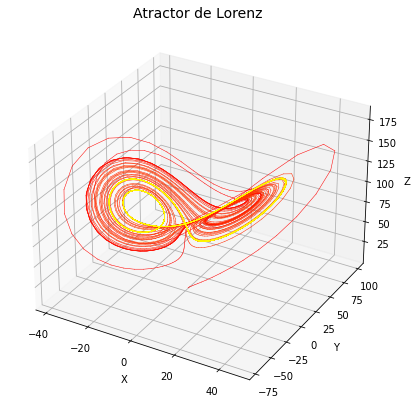

GIF salvo em: lorenz_attractor_case_3.gif


In [15]:
# Executa a simulação
trajectory3 = simulate_lorenz(initial_state3, sigma3, beta3, rho3, dt3, steps3,filename='case3.dat')

# Salva a evolução temporal
output_directory3 = "lorenz_frames_case_3"
save_lorenz_frames(trajectory3, output_directory3,100)
    
# Plota o resultado
plot_lorenz(trajectory3)

# Cria o GIF
gif_output3 = "lorenz_attractor_case_3.gif"
create_gif_from_frames_incremental("lorenz_frames_case_3", gif_output3)

## Analysis
### rho2 = 99.96
- **Behaviour:** At R = 99.96, the system is in a regime of higher turbulence or intense chaotic motion. The system's dynamics become more complex, but the trajectory remains bounded due to the dissipative nature of the equations.
- **Numerical results:** The chaotic attractor is still present, but with a higher density of trajectories and increased complexity in their arrangement. The dynamics exhibit more extreme oscillations, reflecting stronger nonlinear interactions.
- **Graph:** The attractor retains the general butterfly shape but shows more intricate and densely packed trajectories, indicating a higher level of turbulence and chaos.

## Download

In [ ]:
#Compress-Archive -Path "0. Numerical Methods Final Project" -DestinationPath "Numerical_Methods_Project.zip"